In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, classification_report, make_scorer

In [2]:
# 固定随机种子
np.random.seed(42)

In [3]:
known_df = pd.read_excel("已知数据.xlsx")
unknown_df = pd.read_excel("不确定数据.xlsx")

In [4]:
features = ['PR','腋窝淋巴结状态','手术前怀孕','目前月经情况','ki-67','HER2+FISH',
            '治疗后怀孕','治疗后生产','LN转移个数','放疗', '化疗期间是否应用诺雷德',
            '靶向治疗（赫赛汀或赫赛汀+帕捷特）','手术方式','化疗方案','内分泌治疗方案']
continuous_vars = ['PR', 'ki-67']
label_col = '标签'

In [5]:
X_known = known_df[features]
y_known = known_df[label_col]
X_unknown_orig = unknown_df[features]  # 原始未标准化的不确定数据

In [6]:
last_pseudo_labels = np.array([-1]*len(X_unknown_orig))
iteration = 0

In [7]:
while True:
    iteration += 1
    print(f"\n======= 第 {iteration} 次迭代 =======")

    # ===== 从已知数据中划分训练集和测试集 =====
    X_train_known, X_test, y_train_known, y_test = train_test_split(
        X_known, y_known, test_size=0.2, stratify=y_known, random_state=42)

    # ===== 加入伪标签样本到训练集 =====
    if iteration == 1:
        X_train_combined = X_train_known.copy()
        y_train_combined = y_train_known.copy()
        # 计算类别权重
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_known), y=y_known)
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}     
    else:
        X_pseudo = X_unknown_orig.copy()
        y_pseudo = pd.Series(pseudo_labels)
        X_train_combined = pd.concat([X_train_known, X_pseudo], ignore_index=True)
        y_train_combined = pd.concat([y_train_known, y_pseudo], ignore_index=True)
        # 计算类别权重
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_combined), y=y_train_combined)
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
        
    # ===== 标准化（fit on train_combined）=====
    scaler = StandardScaler()
    X_train_scaled = X_train_combined.copy()
    X_test_scaled = X_test.copy()
    X_unknown_scaled = X_unknown_orig.copy()
    X_train_known_scaled = X_train_known.copy()

    X_train_scaled[continuous_vars] = scaler.fit_transform(X_train_combined[continuous_vars])
    X_test_scaled[continuous_vars] = scaler.transform(X_test[continuous_vars])
    X_unknown_scaled[continuous_vars] = scaler.transform(X_unknown_orig[continuous_vars])
    X_train_known_scaled[continuous_vars] = scaler.transform(X_train_known[continuous_vars])

    
    # ===== 模型训练 =====
    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    
    param_grid = {
        'n_estimators': [100, 150],
        'max_depth': [3, 5, 7],
        'min_samples_split': [10, 20],
        'min_samples_leaf': [10, 20],
        'max_features': ['sqrt'],
        'class_weight': [None, 'balanced', class_weight_dict]
    }
    
    f1_scorer = make_scorer(f1_score, pos_label=1)
    
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1
    )
    grid_search.fit(X_train_scaled, y_train_combined)

    best_model = grid_search.best_estimator_

    # ===== 模型评估 =====
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print("最佳参数：", grid_search.best_params_)
    print(f"测试集 Accuracy: {acc:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")
    print("分类报告：\n", classification_report(y_test, y_pred))

    # ===== 训练集评估 =====
    y_train_pred = best_model.predict(X_train_known_scaled)
    y_train_proba = best_model.predict_proba(X_train_known_scaled)[:, 1]

    train_acc = accuracy_score(y_train_known, y_train_pred)
    train_rec = recall_score(y_train_known, y_train_pred)
    train_f1 = f1_score(y_train_known, y_train_pred)
    train_auc = roc_auc_score(y_train_known, y_train_proba)

    print(f"训练集 Accuracy: {train_acc:.4f} | Recall: {train_rec:.4f} | F1: {train_f1:.4f} | AUC: {train_auc:.4f}")
    print("训练集分类报告：\n", classification_report(y_train_known, y_train_pred))

    
    # ===== 不确定样本伪标签预测 =====
    pseudo_labels = best_model.predict(X_unknown_scaled)
    probabilities = best_model.predict_proba(X_unknown_scaled)
    gailv = probabilities[:, 1]  # 取正类的概率
    label_changes = np.sum(pseudo_labels != last_pseudo_labels)
    print(f"伪标签变化数量：{label_changes}")

    if label_changes == 0:
        print("\n✅ 伪标签已收敛，结束迭代。")
        break

    last_pseudo_labels = pseudo_labels


======= 第 1 次迭代 =======
最佳参数： {'class_weight': {0: 0.6183431952662722, 1: 2.6125}, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100}
测试集 Accuracy: 0.6667 | Recall: 0.2917 | F1: 0.2500 | AUC: 0.6111
分类报告：
               precision    recall  f1-score   support

           0       0.82      0.75      0.79       102
           1       0.22      0.29      0.25        24

    accuracy                           0.67       126
   macro avg       0.52      0.52      0.52       126
weighted avg       0.70      0.67      0.68       126

训练集 Accuracy: 0.7944 | Recall: 0.6667 | F1: 0.5541 | AUC: 0.8419
训练集分类报告：
               precision    recall  f1-score   support

           0       0.91      0.82      0.87       405
           1       0.47      0.67      0.55        96

    accuracy                           0.79       501
   macro avg       0.69      0.75      0.71       501
weighted avg       0.83      0.79      0.81       501

伪标签变化

最佳参数： {'class_weight': None, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
测试集 Accuracy: 0.6905 | Recall: 0.4167 | F1: 0.3390 | AUC: 0.6716
分类报告：
               precision    recall  f1-score   support

           0       0.85      0.75      0.80       102
           1       0.29      0.42      0.34        24

    accuracy                           0.69       126
   macro avg       0.57      0.59      0.57       126
weighted avg       0.74      0.69      0.71       126

训练集 Accuracy: 0.7685 | Recall: 0.5521 | F1: 0.4775 | AUC: 0.7810
训练集分类报告：
               precision    recall  f1-score   support

           0       0.89      0.82      0.85       405
           1       0.42      0.55      0.48        96

    accuracy                           0.77       501
   macro avg       0.65      0.69      0.66       501
weighted avg       0.80      0.77      0.78       501

伪标签变化数量：13

======= 第 11 次迭代 =======
最佳参数： {'class_weight': 

最佳参数： {'class_weight': {0: 0.8010335917312662, 1: 1.3304721030042919}, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
测试集 Accuracy: 0.6746 | Recall: 0.5417 | F1: 0.3881 | AUC: 0.7124
分类报告：
               precision    recall  f1-score   support

           0       0.87      0.71      0.78       102
           1       0.30      0.54      0.39        24

    accuracy                           0.67       126
   macro avg       0.58      0.62      0.58       126
weighted avg       0.76      0.67      0.70       126

训练集 Accuracy: 0.7485 | Recall: 0.6146 | F1: 0.4836 | AUC: 0.7922
训练集分类报告：
               precision    recall  f1-score   support

           0       0.90      0.78      0.83       405
           1       0.40      0.61      0.48        96

    accuracy                           0.75       501
   macro avg       0.65      0.70      0.66       501
weighted avg       0.80      0.75      0.77       501

伪标签变化数量：3

=======

In [8]:
gailv

array([0.25760517, 0.78759323, 0.32566812, 0.2565743 , 0.12364776,
       0.87414845, 0.67989108, 0.77008402, 0.5780187 , 0.32712937,
       0.2298572 , 0.8193203 , 0.88546589, 0.92143955, 0.34217972,
       0.76242994, 0.81357317, 0.92006765, 0.74713169, 0.22394264,
       0.0904058 , 0.14607917, 0.17105541, 0.60257201, 0.62008904,
       0.32475085, 0.79410795, 0.27611661, 0.76635111, 0.26186659,
       0.21881197, 0.83075559, 0.17663662, 0.85930395, 0.81411932,
       0.27082237, 0.15136341, 0.84799624, 0.9056078 , 0.8745255 ,
       0.09289395, 0.18533568, 0.88126482, 0.31859001, 0.59068316,
       0.62464624, 0.77369042, 0.20191241, 0.38211119, 0.79572206,
       0.86373207, 0.907445  , 0.78599369, 0.13239299, 0.17428537,
       0.17879398, 0.76632942, 0.8171083 , 0.27610223, 0.21860841,
       0.35746526, 0.68004717, 0.74232557, 0.13877307, 0.79309925,
       0.62883206, 0.6160273 , 0.08634079, 0.23519628, 0.16147451,
       0.13036216, 0.06797879, 0.74735677, 0.795372  , 0.70422

In [10]:
df = pd.DataFrame(gailv)

In [11]:
df.to_excel("结果.xlsx", index=False)

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 各轮次编号：初始为 0，后续为 1 到 22
rounds = list(range(0, 23))

In [3]:
# 每轮新增样本数，初始轮次设为 None（表示为空）
sample_counts = [None, 41, 38, 12, 8, 8, 27, 17, 22, 13, 7, 7, 6, 7, 8, 14, 13, 10, 3, 4, 6, 1, 0]

In [4]:
# 测试集 AUC 值
test_auc = [
    0.6111, 0.6401, 0.6393, 0.6491, 0.6560, 0.6491, 0.6634, 0.6691,
    0.6663, 0.6716, 0.6757, 0.6720, 0.6732, 0.6785, 0.6699, 0.6883,
    0.6908, 0.6977, 0.7124, 0.7055, 0.7124, 0.7112, 0.7124
]

In [5]:
# 创建图形窗口
fig, ax1 = plt.subplots(figsize=(12, 6))

In [6]:
# 主轴：新增样本数
ax1.plot(
    [r for r, s in zip(rounds, sample_counts) if s is not None],
    [s for s in sample_counts if s is not None],
    marker='o',
    linestyle='-',
    color='blue',
    label='The number of label flips'
)
ax1.set_xlabel("Round", fontsize=12)
ax1.set_ylabel("The number of label flips", color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, max([s for s in sample_counts if s is not None]) + 10)  # 留白

(0.0, 51.0)

In [7]:
# 样本数标签
for r, s in zip(rounds, sample_counts):
    if s is not None:
        ax1.text(r, s - 3, str(s), ha='center', va='top', fontsize=8, color='blue')

In [8]:
# 副 Y 轴（测试 AUC）
ax2 = ax1.twinx()
ax2.plot(rounds, test_auc, marker='s', linestyle='--', color='red', label='Test AUC')
ax2.set_ylabel("Test AUC", color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0.6, 0.73)  # 手动设置Y轴范围

(0.6, 0.73)

In [9]:
# AUC数值标签
for r, auc in zip(rounds, test_auc):
    ax2.text(r, auc - 0.004, f"{auc:.3f}", ha='center', va='top', fontsize=8, color='red')

In [10]:
# 合并图例并放在底部中央
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
#plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

In [11]:
# 标题与布局优化
plt.title("The number of label flips and Test AUC per Round", fontsize=14)
plt.xticks(rounds)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

In [12]:
plt.savefig("sample_count_auc.png", dpi=300, bbox_inches='tight')

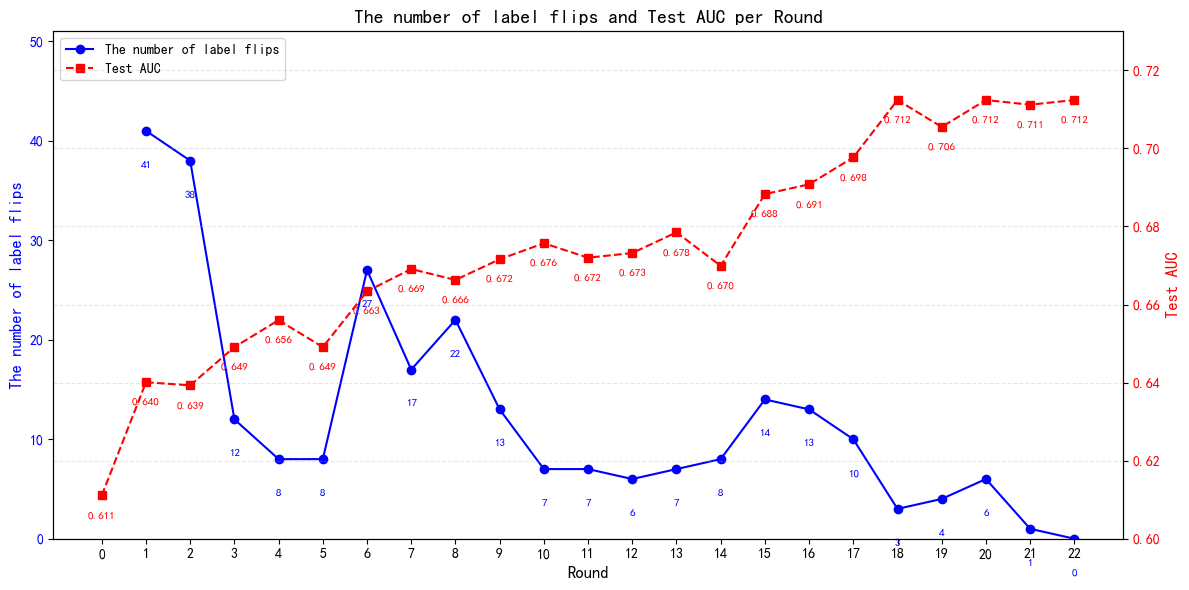

In [13]:
# 显示图形
plt.show()